## Create a cGAN (or cDCGAN) for the MNIST dataset

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

%matplotlib inline
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
#from tensorflow import keras
import glob
import imageio
import PIL
import time
from tensorflow.keras.callbacks import TensorBoard

from IPython import display

In [3]:
TensorBoard()
tf.gfile.MakeDirs(FLAGS.log_dir)
  with tf.Graph().as_default():
    train()
    
tf.Graph()

IndentationError: unexpected indent (<ipython-input-3-dd7a6d0dd82e>, line 3)

In [4]:
TensorBoard(log_dir="logs/{}".format(time()))

TypeError: 'module' object is not callable

In [5]:
train_data = '../../data/Ising/train/'
test_data = '../../data/Ising/test/'
valid_data = '../../data/Ising/valid/'

In [6]:
def one_hot_label(img):
    label,T,_,_ = img.split('_')
    if label == 'low':
        ohl = np.array([1,0])
    elif label == 'high':
        ohl = np.array([0,1])
    return ohl,T
def train_data_with_label(train_path,*args):
    train_images = []
    if args:
        for category in args:
            for i in tqdm(os.listdir(train_path + category)):
                path = os.path.join(train_path, category,i)
                img = np.load(path)
                #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                #img = cv2.resize(img, (128,128))
                train_images.append([img, one_hot_label(i)])
        shuffle(train_images)
        return train_images

def valid_data_with_label(valid_path,*args):
    valid_images = []
    if args:
        for category in args:
            for i in tqdm(os.listdir(valid_path + category)):
                path = os.path.join(valid_path, category,i)
                img = np.load(path)
                #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                #img = cv2.resize(img, (128,128))
                valid_images.append([img, one_hot_label(i)])
        shuffle(valid_images)
        return valid_images
    

In [7]:
train_set=train_data_with_label(train_data,'low','high')

100%|██████████| 7000/7000 [00:01<00:00, 3909.60it/s]


In [8]:
tr_img_data = np.array([i[0] for i in train_set]).reshape(-1,20,20,1)

The numpy array saved from simulations was of type ```int```. We need to convert to type ```float32```.

In [9]:
tr_img_data_float = tr_img_data.astype(dtype='float32')

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_img_data_float).batch(64)

In [11]:
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
callbacks = [
  # Interrupt training if `val_loss` stops improving for over 2 epochs
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    # 1. Create a dense layer, and reshape the output to a 7x7x256 layer
    model.add(tf.keras.layers.Dense(5*5*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((5, 5, 256)))
    assert model.output_shape == (None, 5, 5, 256) # Note: None is the batch size
    
    # 2. Creat a "reverse" convolutional layer and reshape the output to 7x7x128
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 5, 5, 128)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 10, 10, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=tf.tanh))
    assert model.output_shape == (None, 20, 20, 1)
  
    return model

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model

In [15]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [16]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [17]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [18]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

In [19]:
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [20]:
BATCH_SIZE = 64
def train_step(images,gen_loss_log,disc_loss_log):
   # generating noise from a normal distribution
      noise = tf.random_normal([BATCH_SIZE, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        # Round the generator output
        #generated_images_round = tf.round(generated_images)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        gen_loss_log.append(gen_loss)
        disc_loss = discriminator_loss(real_output, generated_output)
        disc_loss_log.append(disc_loss)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  #Add rounding
  predictions = tf.round(model(test_input, training=False))

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')
        
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [22]:
def train(dataset, epochs, gen_loss_log,disc_loss_log):  
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      train_step(images,gen_loss_log,disc_loss_log)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
  #  if (epoch + 1) % 15 == 0:
  #    checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

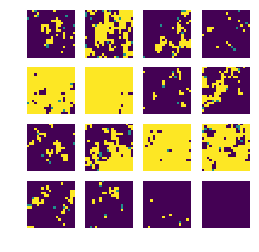

CPU times: user 20min 19s, sys: 46.3 s, total: 21min 5s
Wall time: 19min 53s


In [23]:
%%time
EPOCHS=100
gen_loss_log=[]
disc_loss_log=[]
train(train_dataset, EPOCHS,gen_loss_log,disc_loss_log)

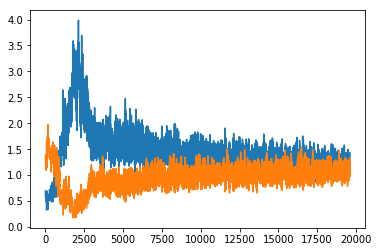

In [24]:
plt.plot(np.asarray(gen_loss_log))
plt.plot(np.asarray(disc_loss_log))

In [25]:
np.save('GeneratorLoss.npy',np.asarray(gen_loss_log))
np.save('DiscriminatorLoss.npy',np.asarray(disc_loss_log))

In [88]:
predictions = generator(random_vector_for_generation, training=False)

In [93]:
pred_round=tf.round(predictions)

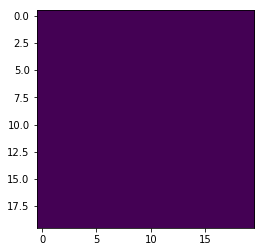

In [94]:
plt.imshow(pred_round[1,:,:,0])

In [91]:
tf.round(predictions)

<tf.Tensor: id=6533247, shape=(16, 20, 20, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
        

In [92]:
predictions

<tf.Tensor: id=6533240, shape=(16, 20, 20, 1), dtype=float32, numpy=
array([[[[-4.9530528e-03],
         [ 1.3222925e-03],
         [ 6.2000970e-03],
         ...,
         [ 1.1532692e-02],
         [-7.9252888e-03],
         [ 1.5444726e-03]],

        [[ 9.9035464e-03],
         [-1.3678454e-02],
         [-9.7377943e-03],
         ...,
         [-6.6972957e-03],
         [ 9.5496950e-04],
         [ 2.4445262e-03]],

        [[ 3.4175243e-04],
         [ 2.4308437e-02],
         [ 7.6974509e-03],
         ...,
         [ 5.5429689e-04],
         [-1.8522412e-02],
         [ 1.5178932e-02]],

        ...,

        [[-1.6759968e-03],
         [ 4.4227419e-03],
         [ 1.4344299e-02],
         ...,
         [-5.0612204e-02],
         [-1.3008295e-02],
         [-2.6867553e-03]],

        [[ 3.0511825e-03],
         [ 9.5128091e-03],
         [-5.0459886e-03],
         ...,
         [-3.3738322e-03],
         [ 9.2948059e-04],
         [ 8.4156832e-03]],

        [[ 3.6019363e-04],


In [ ]:
tf.round()